In [1]:
%matplotlib inline
import numpy as np
import agents as ag
import matplotlib.pyplot as plt

In [2]:
# function to distribute tasks evenly to agents so as to ensure non-overlapping requirement
def split_tasks(num_tasks, num_workers, tasks_per_worker, tasks):
    # for simplicity make sure numbers divide properly
    # and num_tasks/tasks_per_worker = workers/workers_per_task
    if num_tasks % tasks_per_worker != 0:
        raise ValueError("Invalid tasks_per_worker, must divide num_tasks evenly.")
    
    rate = num_tasks/tasks_per_worker
    workers_per_task = num_workers/rate
    
    if workers_per_task*rate != num_workers:
        raise ValueError("Invalid num_workers, must be divisible by num_tasks/tasks_per_worker.")
        
    if workers_per_task <= 1:
        raise ValueError("Workers per task <= 1, not suitable for this mechanism.")
    
    # return dictionary assigning agent to list of tasks
    task_assignments = {}
    for i in range(rate):
        task_assignments[i] = get_tasks(np.arange(tasks_per_worker*i, tasks_per_worker*(i+1)), tasks)
    
    for agent_block in range(1, workers_per_task):
        for idx in range(rate):
            task_assignments[agent_block*rate + idx] = get_tasks(np.arange(idx, idx+rate*(tasks_per_worker), rate), tasks)
    
    return task_assignments

# given tasks get subset of dictionary of tasks
def get_tasks(assignments, tasks):
    return dict(map(lambda x: (x, tasks[x]), assignments))

In [3]:
# setup
N = 100
num_agents = 20
tasks = dict(zip(range(N), np.random.uniform(size=N)>0.5))
task_assignments = split_tasks(N, num_agents, 10, tasks)
num_nonoverlapping = 9

In [4]:
def simulate_rewards(agents, num_nonoverlapping, reward_factor, task_assignments, trials, title, ax=None):
    rewards = []
    for i in range(trials):
        for idx, agent in enumerate(agents):
            agent.reset(task_assignments[idx])
        for agent in agents:
            for idx in agent.tasks:
                #find reference rater who did the same task
                refidx = 0
                while refidx < len(agents) and (idx not in agents[refidx].tasks or agents[refidx] == agent):
                    refidx += 1
                agent.task_score(idx, agents[refidx], num_nonoverlapping, reward_factor)
        rewards.append(agents[0].reward)
    avg = np.mean(rewards)
    if ax is None:
        plt.hist(rewards)
        avg_line = plt.axvline(x=avg, ymin=0, ymax=trials, color='r', linewidth=2, label=avg)
        plt.title(title)
        plt.xlabel("Reward")
        plt.ylabel("Trials")
        plt.legend(handles=[avg_line])
    else:
        ax.hist(rewards)
        avg_line = ax.axvline(x=avg, ymin=0, ymax=trials, color='r', linewidth=2, label=avg)
        ax.set_title(title)
        ax.set_xlabel("Reward")
        ax.set_ylabel("Trials")
        ax.legend(handles=[avg_line])

In [5]:
def plot_scenarios(scenarios, num_nonoverlapping, reward_factor, trials, ncols = 2):
    fig, axes = plt.subplots(nrows=(len(scenarios)+ncols-1)/ncols, ncols=ncols, figsize=(5*ncols,3*(len(scenarios)+ncols-1)/ncols), tight_layout=True)
    for ax, scenario in zip(axes.ravel(), scenarios):
        agents, title = scenario
        simulate_rewards(agents, num_nonoverlapping, reward_factor, task_assignments, trials, title, ax)

In [ ]:
# different scenarios of agents
scenarios = [None]*6
scenarios[0] = ([ag.FullEffortTrueAgent(task_assignments[0])]+[ag.FullEffortTrueAgent(task_assignments[i+1]) for i in range(num_agents-1)], 
                "Full Effort/Truthful (Other Agents Full Effort/Truthful)\n")
scenarios[1] = ([ag.FullEffortFalseAgent(task_assignments[0])] + [ag.FullEffortTrueAgent(task_assignments[i+1]) for i in range(num_agents-1)], 
                "Full Effort/Untruthful (Other Agents Full Effort/Truthful)\n")
scenarios[2] = ([ag.FullEffortFalseAgent(task_assignments[0])]+[ag.FullEffortFalseAgent(task_assignments[i+1]) for i in range(num_agents-1)], 
                "Full Effort/Untruthful (Other Agents Full Effort/Untruthful)\n")
scenarios[3] = ([ag.FullEffortTrueAgent(task_assignments[0])] + [ag.FullEffortFalseAgent(task_assignments[i+1]) for i in range(num_agents-1)], 
                "Full Effort/Truthful (Other Agents Full Effort/Untruthful)\n")
scenarios[4] = ([ag.NoEffortAgent(task_assignments[i]) for i in range(num_agents)], 
                "No Effort (Other Agents No Effort)\n")
scenarios[5] = ([ag.NoEffortAgent(task_assignments[0])] + [ag.FullEffortTrueAgent(task_assignments[i+1]) for i in range(num_agents-1)], 
                "No Effort (Other Agents Full Effort)\n")
plot_scenarios(scenarios, 5, 10, 1000)

In [ ]:
scenarios = [None]*3
scenarios[0] = ([ag.NoEffortAgent(task_assignments[0])] + [ag.RandomEffortTrueAgent(task_assignments[i+1]) for i in range(num_agents-1)],
            "No Effort (Others Random Effort/Truthful)\n")
scenarios[1] = ([ag.RandomEffortTrueAgent(task_assignments[0])]+[ag.RandomEffortTrueAgent(task_assignments[i+1]) for i in range(num_agents-1)],
            "Random Effort/Truthful (Others Random Effort/Truthful)\n")
scenarios[2] = ([ag.FullEffortTrueAgent(task_assignments[0])] + [ag.RandomEffortTrueAgent(task_assignments[i+1]) for i in range(num_agents-1)],
               "Full Effort/Truthful (Others Random Effort/Truthful)\n")
plot_scenarios(scenarios, 5, 10, 1000, 3)

In [6]:
# run trials method for variable effort iteration agent
def run_trials(trials, step_size, agents, agent_idx):
    agent = agents[agent_idx]
    avg_reward = 0
    inc_reward = -np.inf
    dec_reward = -np.inf
    for trial in range(trials):
        # score agent on tasks
        agent.reset(agent.tasks)
        for idx in agent.tasks:
            refidx = 0
            while refidx < len(agents) and (idx not in agents[refidx].tasks or refidx == agent_idx):
                refidx += 1
            agent.task_score(idx, agents[refidx], num_nonoverlapping, reward_factor)
            agent.incur_cost()
        avg_reward += agent.reward*1.0/trials
    #print "Agent {} with effort {}: {}".format(agent_idx, agent.effort, avg_reward)
    if agent.effort < 1:
        # now increment effort and rerun
        agent.inc_effort(step_size)
        inc_reward = 0
        for trial in range(trials):
            # score agent on tasks
            agent.reset(task_assignments[agent_idx])
            for idx in agent.tasks:
                refidx = 0
                while refidx < len(agents) and (idx not in agents[refidx].tasks or refidx == agent_idx):
                    refidx += 1
                agent.task_score(idx, agents[refidx], num_nonoverlapping, reward_factor)
                agent.incur_cost()
            inc_reward += agent.reward*1.0/trials
        agent.inc_effort(-step_size)
        #print "Agent {} with effort {}: {}".format(agent_idx, agent.effort, inc_reward)

    # if inc_reward < avg_reward revert agent's effort
    if agent.effort > 0:
        # now decrement effort and rerun
        agent.inc_effort(-step_size)
        dec_reward = 0
        for trial in range(trials):
            # score agent on tasks
            agent.reset(task_assignments[agent_idx])
            for idx in agent.tasks:
                refidx = 0
                while refidx < len(agents) and (idx not in agents[refidx].tasks or refidx == agent_idx):
                    refidx += 1
                agent.task_score(idx, agents[refidx], num_nonoverlapping, reward_factor)
                agent.incur_cost()
            dec_reward += agent.reward*1.0/trials
        agent.inc_effort(step_size)
        
    max_reward = max(inc_reward, avg_reward, dec_reward)
    if inc_reward == max_reward:
        agent.inc_effort(step_size)
    elif dec_reward == max_reward:
        agent.inc_effort(-step_size)

In [ ]:
# test reward vs. cost
reward_factor = 10
num_iter = 20
trials = 100

rewards = []

for cost_factor in np.arange(0, 10):
    agents = [ag.FullEffortTrueAgent(task_assignments[i]) for i in range(num_agents)]
    reward = 0.0
    for it in range(num_iter-1):
        for agent_idx in range(num_agents):
            agent = agents[agent_idx]
            for trial in range(trials):
                # score agent on tasks
                agent.reset(task_assignments[agent_idx])
                for idx in agent.tasks:
                    refidx = 0
                    while refidx < len(agents) and (idx not in agents[refidx].tasks or refidx == agent_idx):
                        refidx += 1
                    agent.task_score(idx, agents[refidx], num_nonoverlapping, reward_factor)
                    agent.reward -= cost_factor
                reward += agent.reward*1.0/(trials*num_agents*(num_iter-1))
    rewards.append(reward)

In [ ]:
plt.plot(rewards)
plt.title("Reward Beta = 10")
plt.ylabel("Average Reward")
plt.xlabel("Cost")
plt.legend()

In [7]:
# test log vs. linear cost
reward_factor = 10
cost_factor = 0
num_iter = 100
trials = 50
step_size = .05

# linear cost w.r.t. effort
def convex_cost(effort):
    return cost_factor*effort**5
def lin_cost(effort):
    return cost_factor*effort
def log_cost(effort):
    return (np.log(effort+.1) - np.log(.1))*cost_factor/(np.log(1.1) - np.log(.1))

#trace of effort, initialize randomly for agents
effort_trace = np.zeros((num_iter, num_agents))
effort_trace[0, :] = np.random.uniform(size=num_agents)

agents = [ag.VariableEffortTrueAgent(task_assignments[i], lin_cost, effort_trace[0,i], max_prof=np.random.uniform(.75, 1)) for i in range(num_agents)]
for it in range(num_iter-1):
    for agent_idx in range(num_agents):
        run_trials(trials, step_size, agents, agent_idx)
    effort_trace[it+1, :] = np.array(map(lambda agent: agent.effort, agents))

In [ ]:
plt.plot(effort_trace)
plt.ylabel("Effort")
plt.xlabel("Iteration")
plt.ylim([-0.1, 1.1])
#plt.title("Cost={}".format(cost_factor))

In [ ]:
full_prof = effort_trace.copy()

In [ ]:
mid_prof = effort_trace.copy()

In [ ]:
ag_prof = []
for it in range(80, num_iter):
    for ag_idx in range(num_agents):
        if mid_prof[it, ag_idx] < 0.8:
            ag_prof.append(agents[ag_idx].max_prof)
print(np.mean(ag_prof))

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5), tight_layout=True)
ps = axes.ravel()
ps[0].plot(mid_prof)
ps[0].set_ylim([-0.1, 1.1])
ps[1].plot(effort_trace)
ps[1].set_ylim([-0.1, 1.1])
ps[2].plot(full_prof)
ps[2].set_ylim([-0.1, 1.1])
ps[0].set_ylabel("Effort")
ps[0].set_xlabel("Iteration")
ps[1].set_ylabel("Effort")
ps[1].set_xlabel("Iteration")
ps[2].set_ylabel("Effort")
ps[2].set_xlabel("Iteration")
ps[0].set_title("Max Proficiency [0.5,1]")
ps[1].set_title("Max Proficiency [0.75,1]")
ps[2].set_title("Max Proficiency 1")

In [38]:
# remove tasks that are too costly given samples distribution
def check_tasks(samples, agents):
    for i in range(len(samples)):
        for agent in agents:
            if i in agent.tasks and agent.costfunc(agent.effort) > samples[i]:
                agent.tasks.pop(i, None)
                for agent2 in agents:
                    if i in agent2.tasks:
                        agent2.tasks.pop(i, None)

In [40]:
# take it or leave it mechanism
def run_tioli(samples, trials, step_size, agents, agent_idx):
    agent = agents[agent_idx]
    avg_reward = 0
    inc_reward = -np.inf
    dec_reward = -np.inf
    for trial in range(trials):
        # score agent on tasks
        agent.reset(agent.tasks)
        for idx in agent.tasks:
            refidx = 0
            while refidx < len(agents) and (idx not in agents[refidx].tasks or refidx == agent_idx):
                refidx += 1
            non_overlapping = min(len(agents[refidx].tasks), len(agent.tasks)) - 1
            if non_overlapping > 0:
                agent.task_score(idx, agents[refidx], non_overlapping, reward_factor)
                agent.incur_cost()
                agent.reward += samples[idx]
        avg_reward += agent.reward*1.0/trials
    #print "Agent {} with effort {}: {}".format(agent_idx, agent.effort, avg_reward)
    if agent.effort < 1:
        # now increment effort and rerun
        agent.inc_effort(step_size)
        inc_reward = 0
        for trial in range(trials):
            # score agent on tasks
            agent.reset(agent.tasks)
            for idx in agent.tasks:
                refidx = 0
                while refidx < len(agents) and (idx not in agents[refidx].tasks or refidx == agent_idx):
                    refidx += 1
                non_overlapping = min(len(agents[refidx].tasks), len(agent.tasks)) - 1
                if non_overlapping > 0:
                    agent.task_score(idx, agents[refidx], non_overlapping, reward_factor)
                    agent.incur_cost()
                    agent.reward += samples[idx]
            inc_reward += agent.reward*1.0/trials
        agent.inc_effort(-step_size)
        #print "Agent {} with effort {}: {}".format(agent_idx, agent.effort, inc_reward)

    # if inc_reward < avg_reward revert agent's effort
    if agent.effort > 0:
        # now decrement effort and rerun
        agent.inc_effort(-step_size)
        dec_reward = 0
        for trial in range(trials):
            # score agent on tasks
            agent.reset(agent.tasks)
            for idx in agent.tasks:
                refidx = 0
                while refidx < len(agents) and (idx not in agents[refidx].tasks or refidx == agent_idx):
                    refidx += 1
                non_overlapping = min(len(agents[refidx].tasks), len(agent.tasks)) - 1
                if non_overlapping > 0:
                    agent.task_score(idx, agents[refidx], non_overlapping, reward_factor)
                    agent.incur_cost()
                    agent.reward += samples[idx]
            dec_reward += agent.reward*1.0/trials
        agent.inc_effort(step_size)
        
    max_reward = max(inc_reward, avg_reward, dec_reward)
    if inc_reward == max_reward:
        agent.inc_effort(step_size)
    elif dec_reward == max_reward:
        agent.inc_effort(-step_size)

In [128]:
reward_factor = 10
cost_factor = 1
num_iter = 200
trials = 50
step_size = .05

effort_trace = np.zeros((num_iter, num_agents))
effort_trace[0, :] = np.random.uniform(size=num_agents)

agents = [ag.VariableEffortTrueAgent(task_assignments[i], log_cost, effort_trace[0,i], max_prof=np.random.uniform(0.75, 1)) for i in range(num_agents)]
samples = np.random.normal(2, .5, len(tasks))
for it in range(num_iter-1):
    for i in range(num_agents):
        agents[i].reset(task_assignments[i])
    check_tasks(samples, agents)
    
    for agent_idx in range(num_agents):
        run_tioli(samples, trials, step_size, agents, agent_idx)
    effort_trace[it+1, :] = np.array(map(lambda agent: agent.effort, agents))

In [123]:
convex_effort = effort_trace.copy()

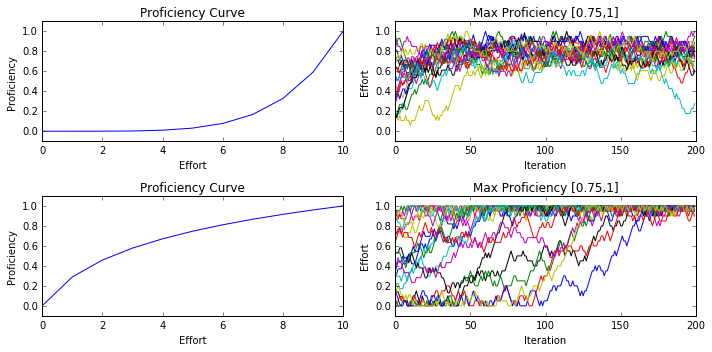

In [130]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,5), tight_layout=True)
ps = axes.ravel()
ps[0].plot(map(lambda x: convex_cost(x), np.arange(0, 1.1, .1)))
ps[0].set_ylim([-0.1, 1.1])
ps[1].plot(convex_effort)
ps[1].set_ylim([-0.1, 1.1])
ps[0].set_ylabel("Proficiency")
ps[0].set_xlabel("Effort")
ps[1].set_ylabel("Effort")
ps[1].set_xlabel("Iteration")
ps[0].set_title("Proficiency Curve")
ps[1].set_title("Max Proficiency [0.75,1]")
ps[2].plot(map(lambda x: log_cost(x), np.arange(0, 1.1, .1)))
ps[2].set_ylim([-0.1, 1.1])
ps[3].plot(effort_trace)
ps[3].set_ylim([-0.1, 1.1])
ps[2].set_ylabel("Proficiency")
ps[2].set_xlabel("Effort")
ps[3].set_ylabel("Effort")
ps[3].set_xlabel("Iteration")
ps[2].set_title("Proficiency Curve")
ps[3].set_title("Max Proficiency [0.75,1]")

In [101]:
full_effort = effort_trace.copy()

In [107]:
mid_effort = effort_trace.copy()

In [86]:
low_effort = effort_trace.copy()

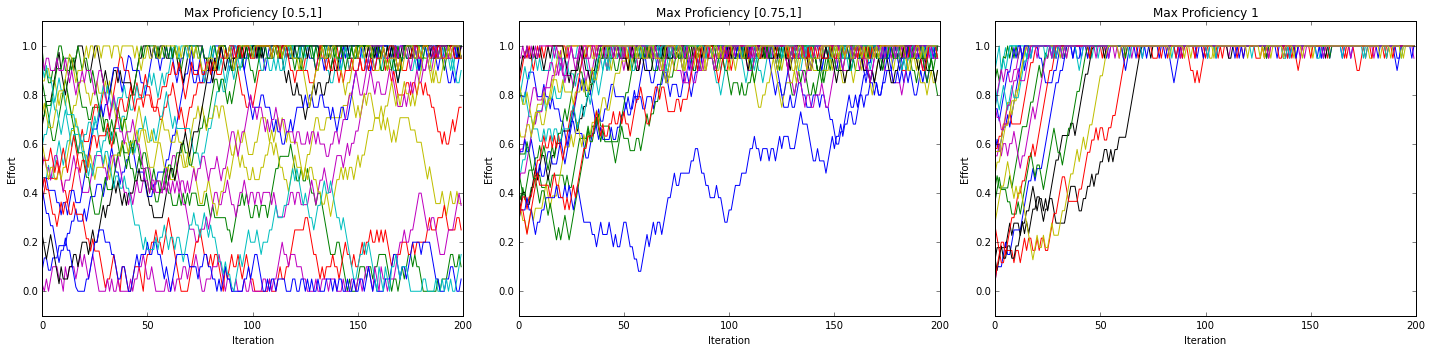

In [108]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,5), tight_layout=True)
ps = axes.ravel()
ps[0].plot(low_effort)
ps[0].set_ylim([-0.1, 1.1])
ps[1].plot(mid_effort)
ps[1].set_ylim([-0.1, 1.1])
ps[2].plot(full_effort)
ps[2].set_ylim([-0.1, 1.1])
ps[0].set_ylabel("Effort")
ps[0].set_xlabel("Iteration")
ps[1].set_ylabel("Effort")
ps[1].set_xlabel("Iteration")
ps[2].set_ylabel("Effort")
ps[2].set_xlabel("Iteration")
ps[0].set_title("Max Proficiency [0.5,1]")
ps[1].set_title("Max Proficiency [0.75,1]")
ps[2].set_title("Max Proficiency 1")